# Kaggle March Madness Challenge 2018

Google Cloud and NCAA® have teamed up to bring you this year’s version of the Kaggle machine learning competition. Another year, another chance to anticipate the upsets, call the probabilities, and put your bracketology skills to the leaderboard test. Kagglers will join the millions of fans who attempt to forecast the outcomes of March Madness® during this year's NCAA Division I Men’s and Women’s Basketball Championships. But unlike most fans, you will pick your bracket using a combination of NCAA’s historical data and your computing power, while the ground truth unfolds on national television.

- Challenge Home: https://www.kaggle.com/c/mens-machine-learning-competition-2018



- Basic Logistic Regression Starter Kernel: https://www.kaggle.com/osciiart/basic-starter-kernel-ncaa-men-s-dataset-with-jp


- Least Squares Starter Kernel: https://www.kaggle.com/baeng72/basic-least-squares-ratings


- NCAA Tournaments Competition Walkthrough: https://www.kaggle.com/asindico/ncaa-tournaments-competition-walkthrough


- Basic Starter Kernel: https://www.kaggle.com/juliaelliott/basic-starter-kernel-ncaa-men-s-dataset


- Feature Engineering with Advanced Statistics: https://www.kaggle.com/lnatml/feature-engineering-with-advanced-stats


- FiveThirtyEight Elo Ratings: https://www.kaggle.com/lpkirwin/fivethirtyeight-elo-ratings


- Extensive NCAA Exploratory Analysis: https://www.kaggle.com/captcalculator/a-very-extensive-ncaa-exploratory-analysis



### Preparation
Import packages and load in initial datasets

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn import model_selection 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = './March Madness 2018/DataFiles/'
df_seeds = pd.read_csv(data_dir + 'NCAATourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'NCAATourneyCompactResults.csv')

In [3]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [4]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


### Seed Based Logistic Regression
Using just seeding the predict winner and confidence, use this as baseline model

In [5]:
# Convert seed to int
df_seeds['Seed_int'] = df_seeds['Seed'].str[1:3]
df_seeds['Seed_int'] = df_seeds['Seed_int'].apply(pd.to_numeric)
df_seeds.head()

,Season,Seed,TeamID,Seed_int
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [6]:
# Drop unnecessary columns
df_seeds.drop(labels=['Seed'], inplace=True, axis=1)
df_tour.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)

In [7]:
df_seeds.head()

,Season,TeamID,Seed_int
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [8]:
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [9]:
# Merge dataframes
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'Seed_int':'WSeed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'Seed_int':'LSeed'})
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


In [10]:
# Create training data set
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,Result
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1


In [11]:
X_train = df_predictions['SeedDiff'].values.reshape(-1,1)
Y_train = df_predictions['Result'].values
X_train, Y_train = shuffle(X_train, Y_train)

In [12]:
# Create and test model
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, Y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5532, with best C: 0.021544346900318846


In [13]:
# Store model results
df_results = pd.DataFrame({'Type': ['Seed Based Logistic Regression'], 'Log Loss': [clf.best_score_]}, columns=['Type', 'Log Loss'])
df_results.head()

,Type,Log Loss
0,Seed Based Logistic Regression,-0.55315


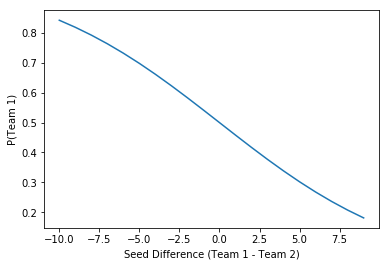

In [14]:
# Vizualization
X = np.arange(-10, 10).reshape(-1, 1);
preds = clf.predict_proba(X)[:,1];

plt.plot(X, preds);
plt.xlabel('Seed Difference (Team 1 - Team 2)');
plt.ylabel('P(Team 1)');

### Average Ranking Based Logistic Regression Model

In [15]:
data_dir = './March Madness 2018/'
df_massey = pd.read_csv(data_dir + 'MasseyOrdinals.csv')

In [16]:
df_massey.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [17]:
# Create composite final rankings
final_day = 133
df_final_rankings = df_massey.loc[df_massey['RankingDayNum'] == final_day]
df_final_rankings = df_final_rankings.groupby(['Season', 'TeamID'])['OrdinalRank'].mean()
df_final_rankings = df_final_rankings.reset_index()
df_final_rankings.rename(columns={'OrdinalRank':'Avg. Rank'}, inplace=True)

In [18]:
df_final_rankings.head()

,Season,TeamID,Avg. Rank
0,2003,1102,156.03125
1,2003,1103,168.00000
2,2003,1104,38.03125
3,2003,1105,308.96875
4,2003,1106,262.68750


In [19]:
data_dir = './March Madness 2018/DataFiles/'
df_tour = pd.read_csv(data_dir + 'NCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT'], inplace=True, axis=1)
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1985,136,1116,63,1234,54
1,1985,136,1120,59,1345,58
2,1985,136,1207,68,1250,43
3,1985,136,1229,58,1425,55
4,1985,136,1242,49,1325,38


In [20]:
# Join tournament results
df_win_ranks = df_final_rankings.rename(columns={'TeamID':'WTeamID', 'Avg. Rank':'WAvgRank'})
df_loss_ranks = df_final_rankings.rename(columns={'TeamID':'LTeamID', 'Avg. Rank':'LAvgRank'})
df_dummy = pd.merge(left=df_tour, right=df_win_ranks, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_ranks, on=['Season', 'LTeamID'])
df_concat['ScoreDiff'] = df_concat['WScore'] - df_concat['LScore']
df_concat['RankDiff'] = df_concat['WAvgRank'] - df_concat['LAvgRank']
df_total = df_concat[['Season', 'DayNum', 'WTeamID','LTeamID', 'WAvgRank', 'LAvgRank', 'RankDiff']]
df_total.head()

,Season,DayNum,WTeamID,LTeamID,WAvgRank,LAvgRank,RankDiff
0,2003,134,1421,1411,240.343750,239.281250,1.062500
1,2003,136,1112,1436,2.676471,153.125000,-150.448529
2,2003,136,1113,1272,36.000000,21.705882,14.294118
3,2003,136,1141,1166,45.687500,20.735294,24.952206
4,2003,136,1143,1301,36.406250,50.312500,-13.906250


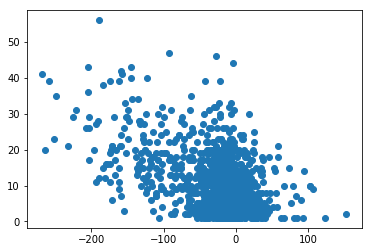

In [21]:
# Is ranking difference correlated with score difference?
plt.scatter(df_concat['RankDiff'], df_concat['ScoreDiff']);

In [22]:
# Create testing and training sets
df_wins = pd.DataFrame()
df_wins['RankDiff'] = df_total['RankDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['RankDiff'] = -df_total['RankDiff']
df_losses['Result'] = 0

In [23]:
df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,RankDiff,Result
0,1.062500,1
1,-150.448529,1
2,14.294118,1
3,24.952206,1
4,-13.906250,1


In [24]:
X_train = df_predictions['RankDiff'].values.reshape(-1,1)
Y_train = df_predictions['Result'].values
X_train, Y_train = shuffle(X_train, Y_train)

In [25]:
# Fit and test model
logreg2 = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, Y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5468, with best C: 0.0016681005372000592


In [26]:
# Store model results
df_results = df_results.append(pd.DataFrame({'Type': ['Avg. Ranking Based Logistic Regression'], 'Log Loss': [clf.best_score_]}, columns=['Type', 'Log Loss']))
df_results.head()

,Type,Log Loss
0,Seed Based Logistic Regression,-0.553150
0,Avg. Ranking Based Logistic Regression,-0.546793


### FiveThirtyEight Elo Logistic Regression Implementation

In [27]:
# Homecourt Bonus
HOME_ADVANTAGE = 100 
# Learning rate
K = 22

In [28]:
# Load regular season data
data_dir = './March Madness 2018/DataFiles/'
rs = pd.read_csv(data_dir + 'RegularSeasonCompactResults.csv')
rs.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [29]:
# Teams
team_ids = set(rs.WTeamID).union(set(rs.LTeamID))
len(team_ids)

364

In [30]:
# Score lookup dict
elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

In [31]:
# New columns to help us iteratively update elos
rs['margin'] = rs.WScore - rs.LScore
rs['w_elo'] = None
rs['l_elo'] = None

In [32]:
# Elo calculation
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))

def expected_margin(elo_diff):
    return((7.5 + 0.006 * elo_diff))

def elo_update(w_elo, l_elo, margin):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return(pred, update)

In [33]:
# Check order
assert np.all(rs.index.values == np.array(range(rs.shape[0]))), "Index is out of order."

In [34]:
# Iterate through all games
preds = []
for i in range(rs.shape[0]):
    
    # Get key data from current row
    w = rs.at[i, 'WTeamID']
    l = rs.at[i, 'LTeamID']
    margin = rs.at[i, 'margin']
    wloc = rs.at[i, 'WLoc']
    
    # Does either team get a home-court advantage?
    w_ad, l_ad, = 0., 0.
    if wloc == "H":
        w_ad += HOME_ADVANTAGE
    elif wloc == "A":
        l_ad += HOME_ADVANTAGE
    
    # Get elo updates as a result of the game
    pred, update = elo_update(elo_dict[w] + w_ad,
                              elo_dict[l] + l_ad, 
                              margin)
    elo_dict[w] += update
    elo_dict[l] -= update
    preds.append(pred)
    
    # Stores new elos in the games dataframe
    rs.loc[i, 'w_elo'] = elo_dict[w]
    rs.loc[i, 'l_elo'] = elo_dict[l]

In [35]:
def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.WTeamID == team_id) | (d.LTeamID == team_id), :]
    d.sort_values(['Season', 'DayNum'], inplace=True)
    d.drop_duplicates(['Season'], keep='last', inplace=True)
    w_mask = d.WTeamID == team_id
    l_mask = d.LTeamID == team_id
    d['season_elo'] = None
    d.loc[w_mask, 'season_elo'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.Season,
        'season_elo': d.season_elo
    })
    return(out)

In [36]:
df_list = [final_elo_per_season(rs, i) for i in team_ids]
season_elos = pd.concat(df_list)

In [37]:
season_elos.head()

,season,season_elo,team_id
134286,2014,1317.05,1101
139681,2015,1201.11,1101
145038,2016,1213.74,1101
150369,2017,1233.86,1101
3606,1985,1404.46,1102


In [38]:
# Logistic Regression
data_dir = './March Madness 2018/DataFiles/'
df_tour = pd.read_csv(data_dir + 'NCAATourneyCompactResults.csv')
df_tour.drop(labels=['DayNum','WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)

df_win_elos = season_elos.rename(columns={'team_id':'WTeamID', 'season':'Season', 'season_elo':'W_Elo'}) #
df_loss_elos = season_elos.rename(columns={'team_id':'LTeamID', 'season':'Season', 'season_elo':'L_Elo'}) #
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])
df_concat['Elo_Diff'] = df_concat['W_Elo'] - df_concat['L_Elo']
df_concat.head()

,Season,WTeamID,LTeamID,W_Elo,L_Elo,Elo_Diff
0,1985,1116,1234,1591.58,1611.14,-19.5577
1,1985,1120,1345,1571.38,1582.63,-11.2464
2,1985,1207,1250,1748.49,1430.35,318.145
3,1985,1229,1425,1582.04,1578.1,3.94023
4,1985,1242,1325,1615.96,1600.98,14.9841


In [39]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins['Elo_Diff'] = df_concat['Elo_Diff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['Elo_Diff'] = -df_concat['Elo_Diff']
df_losses['Result'] = 0

In [40]:
df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Elo_Diff,Result
0,-19.5577,1
1,-11.2464,1
2,318.145,1
3,3.94023,1
4,14.9841,1


In [41]:
X_train = df_predictions['Elo_Diff'].values.reshape(-1,1)
Y_train = df_predictions['Result'].values
X_train, Y_train = shuffle(X_train, Y_train)

In [42]:
# Fit and test model
logreg2 = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, Y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5428, with best C: 0.0001291549665014884


In [43]:
# Store model results
df_results = df_results.append(pd.DataFrame({'Type': ['FiveThirtyEight Elo Logistic Regression'], 'Log Loss': [clf.best_score_]}, columns=['Type', 'Log Loss']))
df_results.head()

,Type,Log Loss
0,Seed Based Logistic Regression,-0.553150
0,Avg. Ranking Based Logistic Regression,-0.546793
0,FiveThirtyEight Elo Logistic Regression,-0.542821


### Select Ranking Systems

In [44]:
data_dir = './March Madness 2018/DataFiles/'
df_tour = pd.read_csv(data_dir + 'NCAATourneyCompactResults.csv')
df_tour.drop(labels=['DayNum','WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [45]:
# Get list of all ranking systems
ranking_types = df_massey['SystemName'].unique().tolist()
ranking_types = [e for e in ranking_types if e not in ('MIC', 'GC', 'RAG', 'TOL', 'EBB', 'BP5', 'MPI', 'BOW', 'CTL')]
print(ranking_types)

['SEL', 'AP', 'BIH', 'DUN', 'ENT', 'GRN', 'IMS', 'MAS', 'MKV', 'MOR', 'POM', 'RPI', 'SAG', 'SAU', 'SE', 'STR', 'USA', 'WLK', 'WOB', 'BOB', 'DWH', 'ERD', 'ECK', 'BRZ', 'ARG', 'RTH', 'WOL', 'HOL', 'COL', 'DOL', 'GRS', 'HER', 'TSR', 'WTE', 'BD', 'MGY', 'CNG', 'SIM', 'DES', 'JON', 'LYN', 'NOR', 'RM', 'REI', 'ACU', 'BCM', 'CMV', 'SAP', 'DC', 'KLK', 'WIL', 'ROH', 'RIS', 'REN', 'SCR', 'DOK', 'PIG', 'KPK', 'PKL', 'TRX', 'MB', 'JCI', 'PH', 'LYD', 'KRA', 'RTR', 'UCS', 'ISR', 'CPR', 'BKM', 'JEN', 'REW', 'STH', 'SPW', 'RSE', 'PGH', 'CPA', 'RTB', 'HKB', 'BPI', 'TW', 'NOL', 'DC2', 'DCI', 'OMY', 'LMC', 'RT', 'KEL', 'KMV', 'RTP', 'TMR', 'AUS', 'ROG', 'PTS', 'KOS', 'PEQ', 'ADE', 'BNM', 'CJB', 'BUR', 'HAT', 'MSX', 'BBT', '7OT', 'SFX', 'EBP', 'TBD', 'CRO', 'D1A', 'TPR', 'BLS', 'DII', 'KBM', 'TRP', 'LOG', 'SP', 'STF', 'WMR', 'PPR', 'STS', 'UPS', 'SPR', 'MvG', 'TRK', 'BWE', 'HAS', 'FSH', 'DAV', 'KPI', 'FAS', 'MCL', 'HRN', 'RSL', 'SMN', 'DDB', 'INP', 'JRT', 'ESR', 'FMG', 'PRR', 'SMS', 'HKS', 'MUZ', 'OCT', '

In [46]:
# Iterate through each ranking and check log loss
def logreg_type(mytype):
    df_type = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == mytype)]
    df_type = df_type.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
    df_type.rename(columns={'OrdinalRank':'Type Rank'}, inplace=True)

    df_win_ranks = df_type.rename(columns={'TeamID':'WTeamID', 'Type Rank':'WTypeRank'})
    df_loss_ranks = df_type.rename(columns={'TeamID':'LTeamID', 'Type Rank':'LTypeRank'})
    df_dummy = pd.merge(left=df_tour, right=df_win_ranks, how='left', on=['Season', 'WTeamID'])
    df_concat = pd.merge(left=df_dummy, right=df_loss_ranks, on=['Season', 'LTeamID'])
    df_concat['RankDiff'] = df_concat['WTypeRank'] - df_concat['LTypeRank']
    df_total = df_concat[['Season', 'WTeamID','LTeamID', 'WTypeRank', 'LTypeRank', 'RankDiff']]
    
    if len(df_total) > 980:
        df_wins = pd.DataFrame()
        df_wins['RankDiff'] = df_total['RankDiff']
        df_wins['Result'] = 1
        df_losses = pd.DataFrame()
        df_losses['RankDiff'] = -df_total['RankDiff']
        df_losses['Result'] = 0

        df_predictions = pd.concat((df_wins, df_losses))

        X_train = df_predictions['RankDiff'].values.reshape(-1,1)
        Y_train = df_predictions['Result'].values
        X_train, Y_train = shuffle(X_train, Y_train)
        if np.isnan(np.sum(X_train)) == False:

            logregtype = LogisticRegression()
            params = {'C': np.logspace(start=-5, stop=5, num=10)}
            clf = GridSearchCV(logregtype, params, scoring='neg_log_loss', refit=True)
            clf.fit(X_train, Y_train)

            print('{} - Best log_loss: {:.4}, with best C: {}'.format(mytype, clf.best_score_, clf.best_params_['C']))
            return(pd.DataFrame({'Type': [mytype], 'Log Loss': [clf.best_score_]}, columns=['Type', 'Log Loss']))
        return(pd.DataFrame({'Type': [mytype], 'Log Loss': [999]}, columns=['Type', 'Log Loss']))
    return(pd.DataFrame({'Type': [mytype], 'Log Loss': [999]}, columns=['Type', 'Log Loss']))

In [47]:
df_type_scores = pd.DataFrame(columns=['Type', 'Log Loss'])
for mytype in ranking_types:
    df_type_scores = df_type_scores.append(logreg_type(mytype))

MOR - Best log_loss: -0.5515, with best C: 0.0001291549665014884
POM - Best log_loss: -0.5514, with best C: 0.0001291549665014884
RPI - Best log_loss: -0.5583, with best C: 0.0001291549665014884
SAG - Best log_loss: -0.5491, with best C: 0.0001291549665014884
WLK - Best log_loss: -0.5523, with best C: 0.0001291549665014884
RTH - Best log_loss: -0.5557, with best C: 0.0001291549665014884
WOL - Best log_loss: -0.5573, with best C: 0.0016681005372000592
COL - Best log_loss: -0.5591, with best C: 0.0001291549665014884
DOL - Best log_loss: -0.5571, with best C: 0.0001291549665014884


In [48]:
df_type_scores = df_type_scores.loc[df_type_scores['Log Loss'] != 999]
df_type_scores.sort_values(by='Log Loss', ascending=False, inplace=True)
df_type_scores

,Type,Log Loss
0,SAG,-0.549115
0,POM,-0.551438
0,MOR,-0.551542
0,WLK,-0.552273
0,RTH,-0.555652
0,DOL,-0.557051
0,WOL,-0.557305
0,RPI,-0.558276
0,COL,-0.559128


### Final Model Selection
Right now, I have a couple different metric options to test, tune, and consider for use in the upcoming tournament:
1. FiveThirtyEight Elo Ratings
2. Average Select Ranking Systems
3. Composite Model

### 1. FiveThirtyEight Elo Ratings Model

In [ ]:
# How does Elo perform alone?
data_dir = './March Madness 2018/DataFiles/'
df_tour = pd.read_csv(data_dir + 'NCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)

df_win_elos = season_elos.rename(columns={'team_id':'WTeamID', 'season_elo':'W_Elo', 'season':'Season'})
df_loss_elos = season_elos.rename(columns={'team_id':'LTeamID', 'season_elo':'L_Elo', 'season':'Season'}) 
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])
df_concat['Elo_Diff'] = df_concat['W_Elo'] - df_concat['L_Elo']
df_concat.head()

In [50]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins['Season'] = df_concat['Season']
df_wins['DayNum'] = df_concat['DayNum']
df_wins['WTeamID'] = df_concat['WTeamID']
df_wins['LTeamID'] = df_concat['LTeamID']

df_wins['Elo_Diff'] = df_concat['Elo_Diff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['Season'] = df_concat['Season']
df_losses['DayNum'] = df_concat['DayNum']
df_losses['WTeamID'] = df_concat['WTeamID']
df_losses['LTeamID'] = df_concat['LTeamID']

df_losses['Elo_Diff'] = -df_concat['Elo_Diff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,DayNum,WTeamID,LTeamID,Elo_Diff,Result
0,1985,136,1116,1234,-19.5577,1
1,1985,136,1120,1345,-11.2464,1
2,1985,136,1207,1250,318.145,1
3,1985,136,1229,1425,3.94023,1
4,1985,136,1242,1325,14.9841,1


In [51]:
# Remove play-in games
df_predictions = df_predictions.loc[df_predictions['DayNum'] > 135]
len(df_predictions)

4158

In [52]:
# Testing and training sets
df_train = df_predictions.loc[df_predictions['Season'] < 2014]
df_test = df_predictions.loc[df_predictions['Season'] >= 2014]

X_train = df_train['Elo_Diff'].values.reshape(-1,1)
Y_train = df_train['Result'].values

X_test = df_test['Elo_Diff'].values.reshape(-1,1)
Y_test = df_test['Result'].values

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, Y_train)
clf.score(X_train, Y_train)

-0.54538007699370672

In [53]:
# 2014-2017 results
Y_pred = clf.predict(X_test)
df_test['Elo_Pred'] = Y_pred
df_test.tail()

,Season,DayNum,WTeamID,LTeamID,Elo_Diff,Result,Elo_Pred
2112,2017,146,1314,1246,17.9249,0,1
2113,2017,146,1376,1196,144.711,0,1
2114,2017,152,1211,1376,-242.598,0,0
2115,2017,152,1314,1332,-45.0282,0,0
2116,2017,154,1314,1211,-10.9314,0,0


In [54]:
# More results
print('Confusion Matrix: ')
print(confusion_matrix(Y_test, Y_pred), '\n')
print(classification_report(Y_test, Y_pred))

Confusion Matrix: 
[[185  67]
 [ 67 185]] 

             precision    recall  f1-score   support

          0       0.73      0.73      0.73       252
          1       0.73      0.73      0.73       252

avg / total       0.73      0.73      0.73       504



### 2. Average Select Ranking Systems
We will pull and average the top performing rankings from our analysis before:
1. SAG 
2. WLK
3. POM
4. MOR

In [55]:
# Pull various system rankings
df_topranks = season_elos.loc[:, season_elos.columns != 'Elo']
df_topranks = df_topranks.rename(columns={'team_id':'Team_ID', 'season':'Season'}) 

df_temp = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == 'SAG')]
df_temp = df_temp.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
df_temp.rename(columns={'OrdinalRank':'SAG', 'TeamID':'Team_ID'}, inplace=True)

df_temp2 = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == 'WLK')]
df_temp2 = df_temp2.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
df_temp2.rename(columns={'OrdinalRank':'WLK', 'TeamID':'Team_ID'}, inplace=True)

df_temp3 = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == 'POM')]
df_temp3 = df_temp3.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
df_temp3.rename(columns={'OrdinalRank':'POM', 'TeamID':'Team_ID'}, inplace=True)

df_temp4 = df_massey.loc[(df_massey['RankingDayNum'] == final_day) & (df_massey['SystemName'] == 'MOR')]
df_temp4 = df_temp4.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
df_temp4.rename(columns={'OrdinalRank':'MOR', 'TeamID':'Team_ID'}, inplace=True)

df_topranks = pd.merge(left=df_topranks, right=df_temp, how='left', on=['Season', 'Team_ID'])
df_topranks = pd.merge(left=df_topranks, right=df_temp2, how='left', on=['Season', 'Team_ID'])
df_topranks = pd.merge(left=df_topranks, right=df_temp3, how='left', on=['Season', 'Team_ID'])
df_topranks = pd.merge(left=df_topranks, right=df_temp4, how='left', on=['Season', 'Team_ID'])

In [56]:
# Mean of all four systems
df_topranks['MeanRank'] = (df_topranks['SAG'] + df_topranks['WLK'] + df_topranks['POM'] + df_topranks['MOR']) / 4
df_topranks.dropna(inplace = True)
df_topranks.head()

,Season,season_elo,Team_ID,SAG,WLK,POM,MOR,MeanRank
0,2014,1317.05,1101,346.0,330.0,348.0,349.0,343.25
1,2015,1201.11,1101,336.0,332.0,332.0,346.0,336.50
2,2016,1213.74,1101,320.0,304.0,318.0,311.0,313.25
3,2017,1233.86,1101,305.0,307.0,300.0,317.0,307.25
22,2003,1452.53,1102,149.0,165.0,160.0,132.0,151.50


In [57]:
# Join with tournament dataframe
data_dir = './March Madness 2018/DataFiles/'
df_tour = pd.read_csv(data_dir + 'NCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)
df_topranks.drop(labels=['SAG', 'WLK', 'POM', 'MOR'], inplace=True, axis=1)

df_win_elos = df_topranks.rename(columns={'Team_ID':'WTeamID', 'MeanRank':'W_MeanRank'})
df_loss_elos = df_topranks.rename(columns={'Team_ID':'LTeamID', 'MeanRank':'L_MeanRank'}) 
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])
df_concat['MeanRank_Diff'] = df_concat['W_MeanRank'] - df_concat['L_MeanRank']
df_concat.head()

,Season,DayNum,WTeamID,LTeamID,season_elo_x,W_MeanRank,season_elo_y,L_MeanRank,MeanRank_Diff
0,2003,134,1421,1411,1318.06,259.50,1288.79,264.50,-5.00
1,2003,136,1112,1436,2051.08,2.75,1442.8,160.50,-157.75
2,2003,136,1113,1272,1787.95,30.00,1833.37,22.00,8.00
3,2003,136,1141,1166,1663.71,45.00,1835.58,24.25,20.75
4,2003,136,1143,1301,1862.13,39.00,1825.56,44.00,-5.00


In [58]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins['Season'] = df_concat['Season']
df_wins['DayNum'] = df_concat['DayNum']
df_wins['WTeamID'] = df_concat['WTeamID']
df_wins['LTeamID'] = df_concat['LTeamID']

df_wins['MeanRank_Diff'] = df_concat['MeanRank_Diff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['Season'] = df_concat['Season']
df_losses['DayNum'] = df_concat['DayNum']
df_losses['WTeamID'] = df_concat['WTeamID']
df_losses['LTeamID'] = df_concat['LTeamID']

df_losses['MeanRank_Diff'] = -df_concat['MeanRank_Diff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,DayNum,WTeamID,LTeamID,MeanRank_Diff,Result
0,2003,134,1421,1411,-5.00,1
1,2003,136,1112,1436,-157.75,1
2,2003,136,1113,1272,8.00,1
3,2003,136,1141,1166,20.75,1
4,2003,136,1143,1301,-5.00,1


In [59]:
# Remove play-in games
df_predictions = df_predictions.loc[df_predictions['DayNum'] > 135]
len(df_predictions)

1890

In [60]:
# Testing and training sets
df_train = df_predictions.loc[df_predictions['Season'] < 2014]
df_test = df_predictions.loc[df_predictions['Season'] >= 2014]

X_train = df_train['MeanRank_Diff'].values.reshape(-1,1)
Y_train = df_train['Result'].values

X_test = df_test['MeanRank_Diff'].values.reshape(-1,1)
Y_test = df_test['Result'].values

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf2 = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf2.fit(X_train, Y_train)
clf2.score(X_train, Y_train)

-0.5450159995753735

In [61]:
# More results
print('Confusion Matrix: ')
print(confusion_matrix(Y_test, Y_pred), '\n')
print(classification_report(Y_test, Y_pred))

Confusion Matrix: 
[[185  67]
 [ 67 185]] 

             precision    recall  f1-score   support

          0       0.73      0.73      0.73       252
          1       0.73      0.73      0.73       252

avg / total       0.73      0.73      0.73       504



### 3. Composite Model
Standardize the elo ratings and rankings and take the mean for logistic regression.

In [62]:
# Set up and drop null rows
season_elos = season_elos.rename(columns={'team_id':'Team_ID', 'season':'Season', 'season_elo':'Elo'}) 
df = pd.merge(left=season_elos, right=df_topranks, how='left', on=['Season', 'Team_ID'])
df.dropna(inplace=True)
df.head()

,Season,Elo,Team_ID,season_elo,MeanRank
0,2014,1317.05,1101,1317.05,343.25
1,2015,1201.11,1101,1201.11,336.50
2,2016,1213.74,1101,1213.74,313.25
3,2017,1233.86,1101,1233.86,307.25
22,2003,1452.53,1102,1452.53,151.50


In [63]:
# Normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
df['Elo_Scaled'] = scaler.fit_transform(df['Elo'].values.reshape(-1,1))
df['MeanRank_Scaled'] = 1 - scaler.fit_transform(df['MeanRank'].values.reshape(-1,1))

In [64]:
# Model 1
df['Composite Score'] = (df['Elo_Scaled'] + (2 * df['MeanRank_Scaled'])) / 3
df.head()

# Model 2
#df['Composite Score'] = (df['Elo_Scaled'] + (df['MeanRank_Scaled'])) / 2
#df.head()

,Season,Elo,Team_ID,season_elo,MeanRank,Elo_Scaled,MeanRank_Scaled,Composite Score
0,2014,1317.05,1101,1317.05,343.25,0.377452,0.022143,0.199798
1,2015,1201.11,1101,1201.11,336.50,0.289849,0.041429,0.165639
2,2016,1213.74,1101,1213.74,313.25,0.299388,0.107857,0.203622
3,2017,1233.86,1101,1233.86,307.25,0.314596,0.125000,0.219798
22,2003,1452.53,1102,1452.53,151.50,0.479827,0.570000,0.524914


In [65]:
# Join tournament dataframe
data_dir = './March Madness 2018/DataFiles/'
df_tour = pd.read_csv(data_dir + 'NCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)
df.drop(labels=['Elo', 'season_elo', 'MeanRank'], inplace=True, axis=1)

df_win_elos = df.rename(columns={'Team_ID':'WTeamID', 'Composite Score':'W_Composite'})
df_loss_elos = df.rename(columns={'Team_ID':'LTeamID', 'Composite Score':'L_Composite'}) 
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])
df_concat['Composite_Diff'] = df_concat['W_Composite'] - df_concat['L_Composite']
df_total = df_concat[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'W_Composite', 'L_Composite', 'Composite_Diff']]
df_total.head()

,Season,DayNum,WTeamID,LTeamID,W_Composite,L_Composite,Composite_Diff
0,2003,134,1421,1411,0.319824,0.301622,0.018201
1,2003,136,1112,1436,0.963552,0.508381,0.455171
2,2003,136,1113,1272,0.825212,0.853798,-0.028586
3,2003,136,1141,1166,0.756841,0.851419,-0.094578
4,2003,136,1143,1301,0.840379,0.819419,0.020960


In [66]:
# Prediction dataframe
df_wins = pd.DataFrame()
df_wins['Season'] = df_concat['Season']
df_wins['DayNum'] = df_concat['DayNum']
df_wins['WTeamID'] = df_concat['WTeamID']
df_wins['LTeamID'] = df_concat['LTeamID']

df_wins['Composite_Diff'] = df_concat['Composite_Diff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['Season'] = df_concat['Season']
df_losses['DayNum'] = df_concat['DayNum']
df_losses['WTeamID'] = df_concat['WTeamID']
df_losses['LTeamID'] = df_concat['LTeamID']

df_losses['Composite_Diff'] = -df_concat['Composite_Diff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,Season,DayNum,WTeamID,LTeamID,Composite_Diff,Result
0,2003,134,1421,1411,0.018201,1
1,2003,136,1112,1436,0.455171,1
2,2003,136,1113,1272,-0.028586,1
3,2003,136,1141,1166,-0.094578,1
4,2003,136,1143,1301,0.020960,1


In [67]:
# Remove play-in games
df_predictions = df_predictions.loc[df_predictions['DayNum'] > 135]
len(df_predictions)

1890

In [68]:
# Testing and training sets
df_train = df_predictions.loc[df_predictions['Season'] < 2014]
df_test = df_predictions.loc[df_predictions['Season'] >= 2014]

X_train = df_train['Composite_Diff'].values.reshape(-1,1)
Y_train = df_train['Result'].values

X_test = df_test['Composite_Diff'].values.reshape(-1,1)
Y_test = df_test['Result'].values

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf3 = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf3

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-05,   1.29155e-04,   1.66810e-03,   2.15443e-02,
         2.78256e-01,   3.59381e+00,   4.64159e+01,   5.99484e+02,
         7.74264e+03,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [69]:
# Training score
clf3.fit(X_train, Y_train)
clf3.score(X_train, Y_train)

-0.5427760668455921

In [70]:
# Save model
filename = 'ncaa_tourney1.pkl'
#filename = 'ncaa_tourney2.pkl'
pickle.dump(clf3, open(filename, 'wb'))

In [71]:
# More results
print('Confusion Matrix: ')
print(confusion_matrix(Y_test, Y_pred), '\n')
print(classification_report(Y_test, Y_pred))

Confusion Matrix: 
[[185  67]
 [ 67 185]] 

             precision    recall  f1-score   support

          0       0.73      0.73      0.73       252
          1       0.73      0.73      0.73       252

avg / total       0.73      0.73      0.73       504



### Model Performance

In [72]:
# 2014-2017 log loss
Y_pred = clf3.predict(X_test)
df_test['Pred'] = Y_pred
clf3.score(X_test, Y_test)

-0.51075848153406123

In [73]:
# Probabilities
probs = clf3.predict_proba(X_test)
Y_prob = [max(item[0],item[1]) for item in probs]
df_test['Prob'] = Y_prob

df_test.head()

,Season,DayNum,WTeamID,LTeamID,Composite_Diff,Result,Pred,Prob
717,2014,136,1163,1386,0.091565,1,1,0.683972
718,2014,136,1173,1326,-0.137862,1,0,0.761780
719,2014,136,1196,1107,0.483541,1,1,0.983329
720,2014,136,1217,1153,-0.080948,1,0,0.664310
721,2014,136,1257,1264,0.271877,1,1,0.908253


In [74]:
# Teams dataframe
data_dir = './March Madness 2018/DataFiles/'
teams = pd.read_csv(data_dir + 'teams.csv')
teams.head()

df_dummy = teams.rename(columns={'TeamID':'WTeamID'})
df_results = pd.merge(left=df_test, right=df_dummy, how='left', on=['WTeamID'])

df_dummy = teams.rename(columns={'TeamID':'LTeamID'})
df_results = pd.merge(left=df_results, right=df_dummy, how='left', on=['LTeamID'])

df_results = df_results.rename(columns={'TeamName_x':'WTeamName', 'TeamName_y':'LTeamName'})
df_results = df_results[['Season', 'DayNum', 'WTeamName', 'LTeamName', 'Composite_Diff', 'Prob', 'Pred', 'Result']]
df_results.drop_duplicates(subset=['Season','DayNum','WTeamName'], keep='last', inplace=True)
df_results.head()

,Season,DayNum,WTeamName,LTeamName,Composite_Diff,Prob,Pred,Result
252,2014,136,Connecticut,St Joseph's PA,-0.091565,0.683972,0,0
253,2014,136,Dayton,Ohio St,0.137862,0.761780,1,0
254,2014,136,Florida,Albany NY,-0.483541,0.983329,0,0
255,2014,136,Harvard,Cincinnati,0.080948,0.664310,1,0
256,2014,136,Louisville,Manhattan,-0.271877,0.908253,0,0


In [75]:
# Wrong answers
incorrect = df_results.loc[df_results['Pred'] != df_results['Result']]
incorrect.sort_values(by='DayNum', ascending=False, inplace=True)
def get_incorrect_year(year):
    incorrect_year = incorrect.loc[incorrect['Season'] == year]
    return(incorrect_year)
get_incorrect_year(2017)

,Season,DayNum,WTeamName,LTeamName,Composite_Diff,Prob,Pred,Result
499,2017,146,North Carolina,Kentucky,0.007129,0.515024,1,0
500,2017,146,South Carolina,Florida,0.091816,0.684429,1,0
498,2017,145,Oregon,Kansas,0.041307,0.586205,1,0
496,2017,144,South Carolina,Baylor,0.089609,0.680396,1,0
492,2017,143,Xavier,Arizona,0.098212,0.695959,1,0
484,2017,139,Michigan,Louisville,0.057800,0.619488,1,0
487,2017,139,South Carolina,Duke,0.121985,0.736642,1,0
479,2017,138,Wisconsin,Villanova,0.091102,0.683126,1,0
475,2017,138,Florida,Virginia,0.024714,0.551910,1,0
480,2017,138,Xavier,Florida St,0.031929,0.566904,1,0


In [76]:
# First round 2017
def get_firstround_year(year):
    first_round = df_results.loc[(df_results['DayNum'] <= 137) & (df_results['Season'] == year)]    
    first_round.sort_values(by='Prob', ascending=False, inplace=True)
    return(first_round)
get_firstround_year(2017)

,Season,DayNum,WTeamName,LTeamName,Composite_Diff,Prob,Pred,Result
452,2017,136,Villanova,Mt St Mary's,-0.553039,0.990653,0,0
466,2017,137,North Carolina,TX Southern,-0.515507,0.987217,0,0
461,2017,137,Kansas,UC Davis,-0.513945,0.987050,0,0
463,2017,137,Louisville,Jacksonville St,-0.484377,0.983444,0,0
445,2017,136,Gonzaga,S Dakota St,-0.424736,0.972917,0,0
462,2017,137,Kentucky,N Kentucky,-0.419841,0.971808,0,0
441,2017,136,Arizona,North Dakota,-0.411020,0.969697,0,0
460,2017,137,Duke,Troy,-0.409618,0.969348,0,0
470,2017,137,UCLA,Kent,-0.302583,0.927667,0,0
467,2017,137,Oregon,Iona,-0.295587,0.923608,0,0


In [77]:
# Best composite scoring teams ever
df_dummy = teams.rename(columns={'TeamID':'Team_ID'})
df_scores = pd.merge(left=df, right=df_dummy, how='left', on=['Team_ID'])
df_scores = df_scores[['Season', 'TeamName', 'Composite Score']]
df_scores.sort_values(by='Composite Score', ascending=False, inplace=True)
df_scores.head(20)

,Season,TeamName,Composite Score
2964,2009,North Carolina,0.999286
2963,2008,North Carolina,0.995707
1100,2006,Duke,0.993241
1966,2011,Kansas,0.990613
4746,2017,Villanova,0.987834
1098,2004,Duke,0.987728
1097,2003,Duke,0.986729
2027,2015,Kentucky,0.985544
1965,2010,Kansas,0.983324
1105,2011,Duke,0.982254


### Stage 1 Submission

In [78]:
# Sample submission dataframe
data_dir = './March Madness 2018/'
sample = pd.read_csv(data_dir + 'SampleSubmissionStage1.csv')
sample.head()

,ID,Pred
0,2014_1107_1110,0.5
1,2014_1107_1112,0.5
2,2014_1107_1113,0.5
3,2014_1107_1124,0.5
4,2014_1107_1140,0.5


In [79]:
# Pull relevant information from ID
sample['Season'] = sample.apply(lambda row: row['ID'][0:4], axis=1)
sample['Team_ID_Low'] = sample.apply(lambda row: row['ID'][5:9], axis=1)
sample['Team_ID_High'] = sample.apply(lambda row: row['ID'][10:14], axis=1)
sample.head()

,ID,Pred,Season,Team_ID_Low,Team_ID_High
0,2014_1107_1110,0.5,2014,1107,1110
1,2014_1107_1112,0.5,2014,1107,1112
2,2014_1107_1113,0.5,2014,1107,1113
3,2014_1107_1124,0.5,2014,1107,1124
4,2014_1107_1140,0.5,2014,1107,1140


In [80]:
# Merge composite scores
df['Season'] = df['Season'].astype(str)
df['Team_ID'] = df['Team_ID'].astype(str)

df_lows = df.rename(columns={'Composite Score':'Score', 'Team_ID':'Team_ID_Low'})
df_highs = df.rename(columns={'Composite Score':'Score', 'Team_ID':'Team_ID_High'})

df_dummy = pd.merge(left=sample, right=df_lows, how='left', on=['Season', 'Team_ID_Low'])
df_concat = pd.merge(left=df_dummy, right=df_highs, on=['Season', 'Team_ID_High'])
df_sample = df_concat.rename(columns={'Score_x':'Score_Low', 'Score_y':'Score_High'})
df_sample['Score_Diff'] = df_sample['Score_Low'] - df_sample['Score_High']
df_full = df_sample
df_sample = df_sample[['ID', 'Score_Low', 'Score_High', 'Score_Diff','Pred']]

In [81]:
# Probabilities
diffs = df_sample['Score_Diff'].values.reshape(-1,1)
probs = clf3.predict_proba(diffs)
Y_prob = [item[1] for item in probs]
df_sample['Pred'] = Y_prob
df_sample.head()

,ID,Score_Low,Score_High,Score_Diff,Pred
0,2014_1107_1110,0.490968,0.589957,-0.098989,0.302656
1,2014_1107_1112,0.490968,0.936298,-0.445330,0.022864
2,2014_1110_1112,0.589957,0.936298,-0.346341,0.051156
3,2014_1107_1113,0.490968,0.781062,-0.290094,0.079725
4,2014_1110_1113,0.589957,0.781062,-0.191105,0.166392


In [82]:
# Submission
df_submission = df_sample[['ID', 'Pred']]
df_submission.head()

,ID,Pred
0,2014_1107_1110,0.302656
1,2014_1107_1112,0.022864
2,2014_1110_1112,0.051156
3,2014_1107_1113,0.079725
4,2014_1110_1113,0.166392


In [83]:
# Write to csv
df_submission.to_csv('stage1_submission.csv', index=None)

### Reformat Data

In [84]:
season_elos = season_elos.rename(columns={'team_id':'Team_ID', 'season':'Season', 'season_elo':'Elo'}) 
df = pd.merge(left=season_elos, right=df_topranks, how='left', on=['Season', 'Team_ID'])
df.dropna(inplace=True)
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
df['Elo_Scaled'] = scaler.fit_transform(df['Elo'].values.reshape(-1,1))
df['MeanRank_Scaled'] = 1 - scaler.fit_transform(df['MeanRank'].values.reshape(-1,1))
df['Composite Score'] = (df['Elo_Scaled'] + df['MeanRank_Scaled']) / 2

data_dir = './March Madness 2018/DataFiles/'
df_tour = pd.read_csv(data_dir + 'NCAATourneyCompactResults.csv')
df_tour.drop(labels=['WLoc', 'NumOT', 'WScore', 'LScore'], inplace=True, axis=1)
df.drop(labels=['Elo', 'season_elo', 'MeanRank'], inplace=True, axis=1)

df_win_elos = df.rename(columns={'Team_ID':'WTeamID', 'Composite Score':'W_Composite'})
df_loss_elos = df.rename(columns={'Team_ID':'LTeamID', 'Composite Score':'L_Composite'}) 
df_dummy = pd.merge(left=df_tour, right=df_win_elos, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_loss_elos, on=['Season', 'LTeamID'])

df_total = df_concat[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'W_Composite', 'L_Composite']]
df_total.head()

,Season,DayNum,WTeamID,LTeamID,W_Composite,L_Composite
0,2003,134,1421,1411,0.319824,0.301622
1,2003,136,1112,1436,0.963552,0.508381
2,2003,136,1113,1272,0.825212,0.853798
3,2003,136,1141,1166,0.756841,0.851419
4,2003,136,1143,1301,0.840379,0.819419


In [85]:
df_total['TeamID_Upper'] = np.where(df_total['WTeamID'] >= df_total['LTeamID'], df_total['WTeamID'], df_total['LTeamID'])
df_total['TeamID_Lower'] = np.where(df_total['LTeamID'] >= df_total['WTeamID'], df_total['WTeamID'], df_total['LTeamID'])

df_total['Composite_Upper'] = np.where(df_total['W_Composite'] >= df_total['L_Composite'], df_total['W_Composite'], df_total['L_Composite'])
df_total['Composite_Lower'] = np.where(df_total['L_Composite'] >= df_total['W_Composite'], df_total['W_Composite'], df_total['L_Composite'])

df_total['Composite_Diff'] = df_total['Composite_Lower'] - df_total['Composite_Upper']
df_total = df_total[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'TeamID_Upper', 'TeamID_Lower', 'Composite_Upper', 'Composite_Lower', 'Composite_Diff']]

df_total.head()

,Season,DayNum,WTeamID,LTeamID,TeamID_Upper,TeamID_Lower,Composite_Upper,Composite_Lower,Composite_Diff
0,2003,134,1421,1411,1421,1411,0.319824,0.301622,-0.018201
1,2003,136,1112,1436,1436,1112,0.963552,0.508381,-0.455171
2,2003,136,1113,1272,1272,1113,0.853798,0.825212,-0.028586
3,2003,136,1141,1166,1166,1141,0.851419,0.756841,-0.094578
4,2003,136,1143,1301,1301,1143,0.840379,0.819419,-0.020960


In [86]:
df_total['Result'] = np.where(df_total['WTeamID'] == df_total['TeamID_Lower'], 1, 0)
df_predictions = df_total.drop(['WTeamID', 'LTeamID'], axis=1)
df_predictions.head()

,Season,DayNum,TeamID_Upper,TeamID_Lower,Composite_Upper,Composite_Lower,Composite_Diff,Result
0,2003,134,1421,1411,0.319824,0.301622,-0.018201,0
1,2003,136,1436,1112,0.963552,0.508381,-0.455171,1
2,2003,136,1272,1113,0.853798,0.825212,-0.028586,1
3,2003,136,1166,1141,0.851419,0.756841,-0.094578,1
4,2003,136,1301,1143,0.840379,0.819419,-0.020960,1


In [87]:
df_train = df_predictions.loc[df_predictions['Season'] < 2014]
df_test = df_predictions.loc[df_predictions['Season'] >= 2014]

X_train = df_train['Composite_Diff'].values.reshape(-1,1)
Y_train = df_train['Result'].values

X_test = df_test['Composite_Diff'].values.reshape(-1,1)
Y_test = df_test['Result'].values

logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=5, num=10)}
clf3 = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf3.fit(X_train, Y_train)
clf3.score(X_train, Y_train)

-0.69278746859047591

### Simplified Elements From Above

In [3]:
def get_teams_df(year):
    
    # Get all teams for all seasons
    stage2_dir = './March Madness 2018/Stage2UpdatedDataFiles/'
    df = pd.read_csv(stage2_dir + 'RegularSeasonCompactResults.csv')

    df = df.loc[df['Season'] == year]
    team_ids = set(df.WTeamID).union(set(df.LTeamID))
    team_list = list(team_ids)
    teams = pd.DataFrame({'Team_ID':team_list})
    teams['Season'] = year
    teams = teams[['Season', 'Team_ID']]
    return(teams)

In [4]:
def get_team_name(id):
    
    # Get school name for a given team id in 2018
    stage2_dir = './March Madness 2018/Stage2UpdatedDataFiles/'
    teams = pd.read_csv(stage2_dir + 'teams.csv')
    name = teams.loc[teams['TeamID'] == id]['TeamName']
    return(name.values[0])

In [5]:
def get_team_id(name):
    
    # Get school name for a given team id in 2018
    stage2_dir = './March Madness 2018/Stage2UpdatedDataFiles/'
    teams = pd.read_csv(stage2_dir + 'teams.csv')
    id = teams.loc[teams['TeamName'] == name]['TeamID']
    return(id.values[0])

In [6]:
def elo_pred(elo1, elo2):
    return(1. / (10. ** (-(elo1 - elo2) / 400.) + 1.))

def expected_margin(elo_diff):
    return((7.5 + 0.006 * elo_diff))

def elo_update(w_elo, l_elo, margin, K):
    elo_diff = w_elo - l_elo
    pred = elo_pred(w_elo, l_elo)
    mult = ((margin + 3.) ** 0.8) / expected_margin(elo_diff)
    update = K * mult * (1 - pred)
    return(pred, update)

def final_elo_per_season(df, team_id):
    d = df.copy()
    d = d.loc[(d.WTeamID == team_id) | (d.LTeamID == team_id), :]
    d.sort_values(['Season', 'DayNum'], inplace=True)
    d.drop_duplicates(['Season'], keep='last', inplace=True)
    w_mask = d.WTeamID == team_id
    l_mask = d.LTeamID == team_id
    d['season_elo'] = None
    d.loc[w_mask, 'season_elo'] = d.loc[w_mask, 'w_elo']
    d.loc[l_mask, 'season_elo'] = d.loc[l_mask, 'l_elo']
    out = pd.DataFrame({
        'team_id': team_id,
        'season': d.Season,
        'season_elo': d.season_elo
    })
    return(out)

In [7]:
def get_elos_df(year):
    
    # Data
    stage2_dir = './March Madness 2018/Stage2UpdatedDataFiles/'
    df = pd.read_csv(stage2_dir + 'RegularSeasonCompactResults.csv')
    
    # Constants
    HOME_ADVANTAGE = 100 
    K = 22
    rs = df.loc[df['Season'] == year]
    rs.reset_index(inplace = True)
    
    # Dictionary for lookups
    team_ids = set(rs.WTeamID).union(set(rs.LTeamID))
    elo_dict = dict(zip(list(team_ids), [1500] * len(team_ids)))

    # Set up columns
    rs['margin'] = rs.WScore - rs.LScore
    rs['w_elo'] = None
    rs['l_elo'] = None
    
    # Iterate through regular season
    preds = []
    for i in range(rs.shape[0]):

        # Get key data from current row
        w = rs.at[i, 'WTeamID']
        l = rs.at[i, 'LTeamID']
        margin = rs.at[i, 'margin']
        wloc = rs.at[i, 'WLoc']

        # Does either team get a home-court advantage?
        w_ad, l_ad, = 0., 0.
        if wloc == "H":
            w_ad += HOME_ADVANTAGE
        elif wloc == "A":
            l_ad += HOME_ADVANTAGE

        # Get elo updates as a result of the game
        pred, update = elo_update(elo_dict[w] + w_ad,
                                  elo_dict[l] + l_ad, 
                                  margin, K)
        elo_dict[w] += update
        elo_dict[l] -= update
        preds.append(pred)

        # Stores new elos in the games dataframe
        rs.loc[i, 'w_elo'] = elo_dict[w]
        rs.loc[i, 'l_elo'] = elo_dict[l]
        
    # Create and return final elo dataframe
    df_list = [final_elo_per_season(rs, i) for i in team_ids]
    season_elos = pd.concat(df_list)
    season_elos.rename(columns={'season':'Season', 'team_id':'Team_ID', 'season_elo':'Elo'}, inplace = True)
    return(season_elos)

In [8]:
def get_elo_score(elos_df, year, team_id):
    
    # Return final elo for a team in a given year
    score = elos_df.loc[(elos_df['season'] == year) & (elos_df['team_id'] == team_id)]['season_elo']
    return(score)

In [9]:
def get_select_ranks_df(year, day):

    # Get select ranking scores dataframe
    data_dir = './March Madness 2018/'
    df = pd.read_csv(data_dir + 'MasseyOrdinals_thruSeason2018_Day128.csv')

    # Get final day
    data_dir = './March Madness 2018/'
    df2 = pd.read_csv(data_dir + 'MasseyOrdinals_2018_133_only_53Systems.csv')
    df = df.append(df2)
    
    # Set up
    teams = get_teams_df(year)
    df_massey = df.loc[df['Season'] == 2018]

    df_temp = df_massey.loc[(df_massey['RankingDayNum'] == day) & (df_massey['SystemName'] == 'SAG')]
    df_temp = df_temp.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
    df_temp.rename(columns={'OrdinalRank':'SAG', 'TeamID':'Team_ID'}, inplace=True)

    df_temp2 = df_massey.loc[(df_massey['RankingDayNum'] == day) & (df_massey['SystemName'] == 'WLK')]
    df_temp2 = df_temp2.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
    df_temp2.rename(columns={'OrdinalRank':'WLK', 'TeamID':'Team_ID'}, inplace=True)

    df_temp3 = df_massey.loc[(df_massey['RankingDayNum'] == day) & (df_massey['SystemName'] == 'POM')]
    df_temp3 = df_temp3.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
    df_temp3.rename(columns={'OrdinalRank':'POM', 'TeamID':'Team_ID'}, inplace=True)

    df_temp4 = df_massey.loc[(df_massey['RankingDayNum'] == day) & (df_massey['SystemName'] == 'MOR')]
    df_temp4 = df_temp4.drop(labels=['RankingDayNum', 'SystemName'], axis=1)
    df_temp4.rename(columns={'OrdinalRank':'MOR', 'TeamID':'Team_ID'}, inplace=True)

    teams = pd.merge(left=teams, right=df_temp, how='left', on=['Season', 'Team_ID'])
    teams = pd.merge(left=teams, right=df_temp2, how='left', on=['Season', 'Team_ID'])
    teams = pd.merge(left=teams, right=df_temp3, how='left', on=['Season', 'Team_ID'])
    teams = pd.merge(left=teams, right=df_temp4, how='left', on=['Season', 'Team_ID'])
    
    # Calculate mean score
    teams['MeanRank'] = (teams['SAG'] + teams['WLK'] + teams['POM'] + teams['MOR']) / 4
    teams.dropna(inplace = True)
    massey_df = teams
    return(massey_df)

In [10]:
def get_select_rank(massey_df, year, day, team_id):
    score = massey_df.loc[(massey_df['Season'] == year) & (massey_df['Team_ID'] == team_id)]['MeanRank']
    return(score)

In [11]:
def get_composite_scores_df(year):
    
    # Get dataframe with composite scores for all teams
    FINAL_DAY = 133
    df = get_teams_df(year)
    ranks = get_select_ranks_df(year, FINAL_DAY)
    season_elos = get_elos_df(year)

    df = pd.merge(left=df, right=season_elos, how='left', on=['Season', 'Team_ID'])
    df = pd.merge(left=df, right=ranks, how='left', on=['Season', 'Team_ID'])
    df = df[['Season', 'Team_ID', 'MeanRank', 'Elo']]

    # Normalize features
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    df['Elo_Scaled'] = scaler.fit_transform(df['Elo'].values.reshape(-1,1))
    df['MeanRank_Scaled'] = 1 - scaler.fit_transform(df['MeanRank'].values.reshape(-1,1))

    # Average rankings
    df['Composite Score'] = (df['Elo_Scaled'] + (2 * df['MeanRank_Scaled'])) / 3
    df = df[['Season', 'Team_ID', 'Composite Score']]
    final_scores = df
    return(final_scores)

In [12]:
def generate_probs(model, year):
    data_dir = './March Madness 2018/'
    sample = pd.read_csv(data_dir + 'SampleSubmissionStage2.csv')

    sample['Season'] = sample.apply(lambda row: row['ID'][0:4], axis=1)
    sample['Team_ID_Low'] = sample.apply(lambda row: row['ID'][5:9], axis=1)
    sample['Team_ID_High'] = sample.apply(lambda row: row['ID'][10:14], axis=1)
    sample.head()

    df = get_composite_scores_df(year)
    df = final_scores
    df['Season'] = df['Season'].astype(str)
    df['Team_ID'] = df['Team_ID'].astype(str)

    df_lows = df.rename(columns={'Composite Score':'Score', 'Team_ID':'Team_ID_Low'})
    df_highs = df.rename(columns={'Composite Score':'Score', 'Team_ID':'Team_ID_High'})

    df_dummy = pd.merge(left=sample, right=df_lows, how='left', on=['Season', 'Team_ID_Low'])
    df_concat = pd.merge(left=df_dummy, right=df_highs, on=['Season', 'Team_ID_High'])
    df_sample = df_concat.rename(columns={'Score_x':'Score_Low', 'Score_y':'Score_High'})
    df_sample['Score_Diff'] = df_sample['Score_Low'] - df_sample['Score_High']
    df_full = df_sample
    df_sample = df_sample[['ID', 'Score_Low', 'Score_High', 'Score_Diff','Pred']]

    diffs = df_sample['Score_Diff'].values.reshape(-1,1)
    probs = model.predict_proba(diffs)
    Y_prob = [item[1] for item in probs]
    df_sample['Pred'] = Y_prob
    df_sample = df_sample[['ID', 'Pred']]
    return(df_sample)

### 2018 Results EDA

In [14]:
# Import data
stage2_dir = './March Madness 2018/Stage2UpdatedDataFiles/'
df = pd.read_csv(stage2_dir + 'RegularSeasonCompactResults.csv')
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [15]:
# Run composite score functions
final_scores = get_composite_scores_df(2018)
final_scores.head()

,Season,Team_ID,Composite Score
0,2018,1101,0.295815
1,2018,1102,0.328263
2,2018,1103,0.292680
3,2018,1104,0.780949
4,2018,1105,0.000265


In [16]:
# Pull team names and format data
final_teams = final_scores
pd.options.display.float_format = '{:.3f}'.format

final_teams['Team Name'] = None
for index, rows in final_teams.iterrows():
    final_teams['Team Name'][index] = get_team_name(final_teams['Team_ID'][index])

final_teams = final_teams[['Season', 'Team Name', 'Composite Score']]
final_teams.sort_values(by='Composite Score', ascending = False, inplace = True)

final_teams.reset_index(inplace = True, drop = True)
final_teams.index += 1

In [17]:
# Look at rankings
final_teams.head(25)

,Season,Team Name,Composite Score
1,2018,Villanova,1.000
2,2018,Virginia,0.997
3,2018,Cincinnati,0.976
4,2018,Gonzaga,0.975
5,2018,Duke,0.962
6,2018,Purdue,0.960
7,2018,Michigan St,0.953
8,2018,Michigan,0.947
9,2018,North Carolina,0.930
10,2018,Kansas,0.926


### Submission I

In [19]:
# Sample data
data_dir = './March Madness 2018/'
sample = pd.read_csv(data_dir + 'SampleSubmissionStage2.csv')
sample.head()

,ID,Pred
0,2018_1104_1112,0.500
1,2018_1104_1113,0.500
2,2018_1104_1116,0.500
3,2018_1104_1120,0.500
4,2018_1104_1137,0.500


In [20]:
# Get probability dataframe
mod1 = pickle.load(open('ncaa_tourney1.pkl', 'rb'))
pred = generate_probs(mod1, 2018)
pred.head()

,ID,Pred
0,2018_1104_1112,0.237
1,2018_1104_1113,0.500
2,2018_1112_1113,0.763
3,2018_1104_1116,0.400
4,2018_1112_1116,0.682


In [21]:
# Write to csv
pred.to_csv('stage2_submission1.csv', index=None)

### Submission II

In [22]:
# Get probability dataframe
mod2 = pickle.load(open('ncaa_tourney2.pkl', 'rb'))
pred = generate_probs(mod2, 2018)
pred.head()

,ID,Pred
0,2018_1104_1112,0.244
1,2018_1104_1113,0.500
2,2018_1112_1113,0.755
3,2018_1104_1116,0.404
4,2018_1112_1116,0.677


In [23]:
# Write to csv
pred.to_csv('stage2_submission2.csv', index=None)

In [13]:
get_team_id('Virginia Tech')

1439

In [14]:
get_team_id('Villanova')

1437